# ASGS GeoNames Pipeline

## Required Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile
import pyogrio

## Required Files

### Create required directories

In [2]:
Path('geonames/').mkdir(exist_ok=True)

Path('asgs/').mkdir(exist_ok=True)

### GeoNames Australian Postcodes

In [3]:
gnames_au_postcodes = 'https://download.geonames.org/export/zip/AU.zip'
urlretrieve(gnames_au_postcodes,'geonames_au_postcodes.zip')

with ZipFile('geonames_au_postcodes.zip','r') as zip:
    zip.extract('AU.txt', path='geonames')
    
Path(Path.cwd() / 'geonames' / 'AU.txt').rename(Path.cwd() / 'geonames' / 'au_postcodes.txt')

Path(Path.cwd() / 'geonames_au_postcodes.zip').unlink()

### ASGS Files

In [4]:
asgs_geopackages = {'asgs_main.zip': 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/ASGS_2021_MAIN_STRUCTURE_GPKG_GDA2020.zip',
                    'asgs_indigenous.zip': 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/ASGS_Ed3_2021_Indigenous_Structure_GDA2020_GPKG.zip',
                    'asgs_non_abs.zip': 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.zip',
                    'asgs_urban_section_state.zip': 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/ASGS_2021_SUA_UCL_SOS_SOSR_GPKG_GDA2020.zip',
                    'asgs_remoteness.zip': 'https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/ASGS_Ed3_2021_RA_GPKG_GDA2020.zip'
                   }

asgs_paths = {}

for zip_name, link in asgs_geopackages.items():
    urlretrieve(link, zip_name)

    with ZipFile(zip_name,'r') as zip:
        for file in zip.namelist():
            if '.gpkg' in file:
                zip.extract(file, path='asgs')
                asgs_paths[zip_name[:-4]] = Path(Path.cwd() / 'asgs' / file)

    Path(Path.cwd() / zip_name).unlink()

## Code

In [5]:
asgs_paths

{'asgs_main': PosixPath('/home/hobbymath42/Projects/asgs_geonames_pipeline/asgs/ASGS_2021_Main_Structure_GDA2020.gpkg'),
 'asgs_indigenous': PosixPath('/home/hobbymath42/Projects/asgs_geonames_pipeline/asgs/ASGS_Ed3_2021_Indigenous_Structure_GDA2020.gpkg'),
 'asgs_non_abs': PosixPath('/home/hobbymath42/Projects/asgs_geonames_pipeline/asgs/ASGS_Ed3_Non_ABS_Structures_GDA2020_updated_2024.gpkg'),
 'asgs_urban_section_state': PosixPath('/home/hobbymath42/Projects/asgs_geonames_pipeline/asgs/ASGS_2021_SUA_UCL_SOS_SOSR_GPKG_GDA2020.gpkg'),
 'asgs_remoteness': PosixPath('/home/hobbymath42/Projects/asgs_geonames_pipeline/asgs/ASGS_Ed3_2021_RA_GDA2020.gpkg')}

In [6]:
pyogrio.list_layers(asgs_paths['asgs_main'])

array([['MB_2021_AUST_GDA2020', 'Unknown'],
       ['SA2_2021_AUST_GDA2020', 'Unknown'],
       ['SA1_2021_AUST_GDA2020', 'Unknown'],
       ['SA3_2021_AUST_GDA2020', 'Unknown'],
       ['SA4_2021_AUST_GDA2020', 'Unknown'],
       ['GCCSA_2021_AUST_GDA2020', 'Unknown'],
       ['STE_2021_AUST_GDA2020', 'Unknown'],
       ['AUS_2021_AUST_GDA2020', 'Unknown']], dtype=object)

### GeoNames Postcodes

In [46]:
au_postcodes_cols = ['country_code','postal_code','place_name','admin_name1','admin_code1','admin_name2','admin_code2','admin_name3','admin_code3','latitude','longitude','accuracy']

au_postcodes_df = (pd.read_csv(Path.cwd() / 'geonames' / 'au_postcodes.txt', delimiter='\t', header=None, names=au_postcodes_cols)
                   [['postal_code', 'place_name', 'latitude', 'longitude']])

au_postcodes_df

,postal_code,place_name,latitude,longitude
0,200,Australian National University,-35.2777,149.1189
1,221,Barton,-35.3049,149.1412
2,2540,Jervis Bay,-35.1499,150.6969
3,2540,Hmas Creswell,-35.0280,150.5501
4,2540,Wreck Bay,-35.1648,150.6908
...,...,...,...,...
16868,6989,Maddington,-32.0500,115.9833
16869,6990,Gosnells,-32.0810,116.0054
16870,6991,Kelmscott,-32.1243,116.0259
16871,6992,Armadale,-32.1461,116.0093


<Axes: >

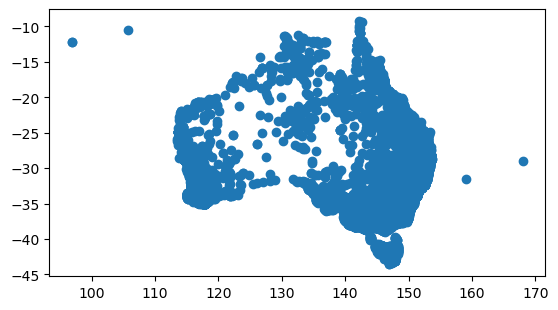

In [47]:
au_postcodes_gdf = (gpd.GeoDataFrame(au_postcodes_df, geometry=gpd.points_from_xy(au_postcodes_df['longitude'], au_postcodes_df['latitude']), crs="EPSG:7844")
                    [['postal_code', 'place_name', 'geometry']]
                   )

au_postcodes_gdf.plot()

In [48]:
au_postcodes_gdf.to_file('test.gpkg', driver='GPKG', layer='layer1', mode='w', index=False)

<Axes: >

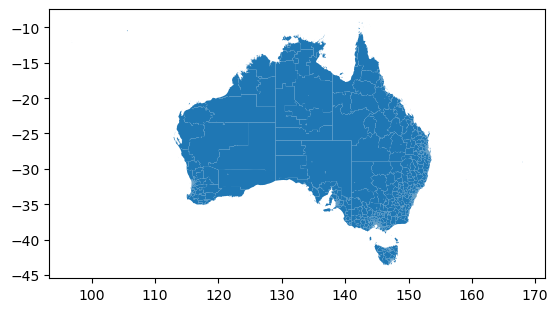

In [49]:
asgs_gdf = (gpd.read_file(asgs_paths['asgs_main'], layer='SA2_2021_AUST_GDA2020')
            .query('not(geometry.isna())')
           )

asgs_gdf = (asgs_gdf
            [[asgs_gdf.columns[0], asgs_gdf.columns[1], asgs_gdf.columns[-1]]]
            .rename(columns={asgs_gdf.columns[0]:asgs_gdf.columns[0].lower(),
                     asgs_gdf.columns[1]: asgs_gdf.columns[1].lower()
                    })
           )

asgs_gdf[f'SA2_2021_AUST_GDA2020_geometry'.lower()] = asgs_gdf.geometry

asgs_gdf.plot()

In [50]:
initial_merge_gdf = (au_postcodes_gdf
                  .to_crs(asgs_gdf.crs)
                  .sjoin(asgs_gdf, how='left', lsuffix='geonames', rsuffix='asgs', predicate='within')
                 )

initial_merge_gdf

,postal_code,place_name,geometry,index_asgs,sa2_code_2021,sa2_name_2021,sa2_2021_aust_gda2020_geometry
0,200,Australian National University,POINT (149.11890 -35.27770),2385.0,801051049,Acton,"MULTIPOLYGON (((149.11002 -35.28400, 149.11048..."
1,221,Barton,POINT (149.14120 -35.30490),2405.0,801061066,Lake Burley Griffin,"MULTIPOLYGON (((149.11366 -35.29765, 149.11374..."
2,2540,Jervis Bay,POINT (150.69690 -35.14990),2468.0,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
3,2540,Hmas Creswell,POINT (150.55010 -35.02800),290.0,114011281,Tomerong - Wandandian - Woollamia,"MULTIPOLYGON (((150.50513 -35.05076, 150.50401..."
4,2540,Wreck Bay,POINT (150.69080 -35.16480),2468.0,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
...,...,...,...,...,...,...,...
16868,6989,Maddington,POINT (115.98330 -32.05000),2043.0,506041136,Maddington - Orange Grove - Martin,"MULTIPOLYGON (((115.97321 -32.04859, 115.97191..."
16869,6990,Gosnells,POINT (116.00540 -32.08100),2041.0,506041134,Gosnells,"MULTIPOLYGON (((115.97838 -32.07704, 115.97830..."
16870,6991,Kelmscott,POINT (116.02590 -32.12430),2017.0,506011114,Kelmscott,"MULTIPOLYGON (((116.01268 -32.10998, 116.01145..."
16871,6992,Armadale,POINT (116.00930 -32.14610),2014.0,506011110,Armadale - Wungong - Brookdale,"MULTIPOLYGON (((115.99878 -32.13946, 115.99802..."


In [51]:
initial_merge_success_gdf = initial_merge_gdf.query('not(index_asgs.isna())')

initial_merge_success_gdf

,postal_code,place_name,geometry,index_asgs,sa2_code_2021,sa2_name_2021,sa2_2021_aust_gda2020_geometry
0,200,Australian National University,POINT (149.11890 -35.27770),2385.0,801051049,Acton,"MULTIPOLYGON (((149.11002 -35.28400, 149.11048..."
1,221,Barton,POINT (149.14120 -35.30490),2405.0,801061066,Lake Burley Griffin,"MULTIPOLYGON (((149.11366 -35.29765, 149.11374..."
2,2540,Jervis Bay,POINT (150.69690 -35.14990),2468.0,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
3,2540,Hmas Creswell,POINT (150.55010 -35.02800),290.0,114011281,Tomerong - Wandandian - Woollamia,"MULTIPOLYGON (((150.50513 -35.05076, 150.50401..."
4,2540,Wreck Bay,POINT (150.69080 -35.16480),2468.0,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
...,...,...,...,...,...,...,...
16868,6989,Maddington,POINT (115.98330 -32.05000),2043.0,506041136,Maddington - Orange Grove - Martin,"MULTIPOLYGON (((115.97321 -32.04859, 115.97191..."
16869,6990,Gosnells,POINT (116.00540 -32.08100),2041.0,506041134,Gosnells,"MULTIPOLYGON (((115.97838 -32.07704, 115.97830..."
16870,6991,Kelmscott,POINT (116.02590 -32.12430),2017.0,506011114,Kelmscott,"MULTIPOLYGON (((116.01268 -32.10998, 116.01145..."
16871,6992,Armadale,POINT (116.00930 -32.14610),2014.0,506011110,Armadale - Wungong - Brookdale,"MULTIPOLYGON (((115.99878 -32.13946, 115.99802..."


In [52]:
initial_merge_missing_gdf = (initial_merge_gdf
                             .query('index_asgs.isna()')
                             [au_postcodes_gdf.columns]
                             .to_crs(asgs_gdf.crs)
                             .sjoin_nearest(asgs_gdf, how='left', lsuffix='geonames', rsuffix='asgs')
                            )
initial_merge_missing_gdf

/home/hobbymath42/miniconda3/envs/asgs_geonames/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,postal_code,place_name,geometry,index_asgs,sa2_code_2021,sa2_name_2021,sa2_2021_aust_gda2020_geometry
468,2000,Sydney,POINT (151.20020 -33.87180),366,117031645,Sydney (South) - Haymarket,"MULTIPOLYGON (((151.19852 -33.87579, 151.19855..."
524,2027,Hmas Rushcutters,POINT (151.24440 -33.86880),379,118011650,Double Bay - Darling Point,"MULTIPOLYGON (((151.24500 -33.87377, 151.24486..."
534,2031,Clovelly,POINT (151.26680 -33.91380),387,118021651,Coogee - Clovelly,"MULTIPOLYGON (((151.26545 -33.92630, 151.26559..."
541,2035,Maroubra,POINT (151.25910 -33.95360),388,118021652,Malabar - La Perouse,"MULTIPOLYGON (((151.23674 -33.97692, 151.23655..."
547,2036,Port Botany,POINT (151.21570 -33.98250),346,117011324,Port Botany Industrial,"MULTIPOLYGON (((151.22091 -33.96895, 151.22062..."
...,...,...,...,...,...,...,...
16636,6701,North Plantations,POINT (113.65900 -24.85800),2140,511021276,Carnarvon,"MULTIPOLYGON (((113.64121 -24.89710, 113.64128..."
16646,6707,Learmonth,POINT (114.08830 -22.17660),2141,511021277,Exmouth,"MULTIPOLYGON (((114.35695 -22.48784, 114.35731..."
16690,6721,Port Hedland,POINT (118.60900 -20.32820),2133,510021269,Port Hedland,"MULTIPOLYGON (((118.57688 -20.30967, 118.57641..."
16762,6799,West Island Cocos (Keeling) Islands,POINT (96.86280 -12.13520),2467,901021002,Cocos (Keeling) Islands,"MULTIPOLYGON (((96.91512 -12.14044, 96.91508 -..."


In [53]:
full_merge_gdf = (pd.concat([initial_merge_success_gdf, initial_merge_missing_gdf],ignore_index=True)
                  .drop(columns=['index_asgs', 'geometry'])
                  .rename(columns={'sa2_2021_aust_gda2020_geometry':'geometry'})
                  [[asgs_gdf.columns[0], asgs_gdf.columns[1], asgs_gdf.columns[2]]]
                 )

del initial_merge_gdf, initial_merge_success_gdf, initial_merge_missing_gdf

full_merge_gdf

,sa2_code_2021,sa2_name_2021,geometry
0,801051049,Acton,"MULTIPOLYGON (((149.11002 -35.28400, 149.11048..."
1,801061066,Lake Burley Griffin,"MULTIPOLYGON (((149.11366 -35.29765, 149.11374..."
2,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
3,114011281,Tomerong - Wandandian - Woollamia,"MULTIPOLYGON (((150.50513 -35.05076, 150.50401..."
4,901031003,Jervis Bay,"MULTIPOLYGON (((150.69567 -35.18295, 150.69513..."
...,...,...,...
16868,511021276,Carnarvon,"MULTIPOLYGON (((113.64121 -24.89710, 113.64128..."
16869,511021277,Exmouth,"MULTIPOLYGON (((114.35695 -22.48784, 114.35731..."
16870,510021269,Port Hedland,"MULTIPOLYGON (((118.57688 -20.30967, 118.57641..."
16871,901021002,Cocos (Keeling) Islands,"MULTIPOLYGON (((96.91512 -12.14044, 96.91508 -..."


In [55]:
full_merge_gdf.to_file('test.gpkg', driver='GPKG', layer='layer2', index=False)